# 深度学习基础

导入包

In [51]:
%matplotlib widget
import math
import os
import random

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.datasets import fashion_mnist
from torch.utils import data
from torchvision import transforms

InteractiveShell.ast_node_interactivity = "all"

d2l.plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
d2l.plt.rcParams['axes.unicode_minus'] = False  # 显示负号

信任当前文件

In [46]:
!jupyter trust 2.线性神经网络.ipynb

Signing notebook: 2.线性神经网络.ipynb


加速jupyterlab补全, 但是会停用函数内代码提示等功能

In [3]:
# %config Completer.use_jedi = False

## 以简化的房价预测模型为例

- 假设1: 影响房价$y$的关键因素是`住房面积`$x_1$、和`房龄`$x_3$
- 假设2: `成交价`$y$是关键因素的加权和，即$y= w_1 x_1+w_2 x_2+b$


损失函数
- 平方损失: $l(y,\widehat{y}) = \frac{1}{2} (y-\widehat{y})^2$

假设样本数n
$$X = [x_1,x_2,\dots,x_n]^T$$
$$y = [y_1,y_2,\dots,y_n]^T$$

训练损失
$$l(X,y,w,b)=\frac{1}{2n} \sum_{i=1}^{n}(y_i - \left \langle x_i,w \right \rangle -b)^2 = \frac{1}{2n} \left \| y-Xw-b \right \|^2$$

最小化损失来学习参数
$$w^*,b^*= arg\min_{w,b} l(X,y,w,b)$$

## 矢量化（vectorization）加速

矢量化编程就是尽可能的避免显示的for循环，尽量使用矩阵运算来代替，从而发挥python中矩阵运算的优势，大大降低时间代价。

遇到数据量很大的for循环运算，就立刻思考是否能用矩阵运算代替。

In [4]:
a = torch.ones(100000)
b = torch.ones(100000)

### 未矢量化的测试

In [5]:
%%time
c = torch.zeros(len(a))
for i in range(len(a)):
    c[i] = a[i]+b[i]
c

Wall time: 935 ms


tensor([2., 2., 2.,  ..., 2., 2., 2.])

### 矢量化后的测试

In [6]:
%%time
c = torch.zeros(len(a))
c = a+b
c

Wall time: 0 ns


tensor([2., 2., 2.,  ..., 2., 2., 2.])

通过上述的测试，可以看出“矢量化”可以极大的提高计算速度。

## 线性回归的实现


训练数据集的样本数为1000，输入的特征数是2，权重$w=[2,-3.4]^T$，偏差$b=4.2$，随机噪声$\epsilon $，生成标签：
$$y=Xw+b+\epsilon $$

其中$\epsilon $服从均值为0，标准差为0.01的正态分布。代表无意义的干扰。

### 生成数据集

In [52]:
# 固定seed，使得normal生成的数据集固定
torch.manual_seed(1)

# 生成 features
features = torch.normal(mean=0, std=1, size=(1000, 2))
print("features :", features)

# 生成 w
w = torch.tensor([2, -3.4])
print("w :", w)


# 生成 c
c = torch.normal(mean=0, std=0.01, size=[1000])
print("shape(c) =", c.shape)

b = 4.2

# 计算得到 labels
labels = torch.matmul(features, w) + b + c

features : tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        ...,
        [ 2.0441, -1.3229],
        [ 1.0491, -2.2162],
        [ 1.0833,  1.5990]])
w : tensor([ 2.0000, -3.4000])
shape(c) = torch.Size([1000])


### 可视化训练样本

In [53]:
features[:50, 0]
features[:50, 1]

tensor([-1.5256, -0.6540, -0.1002, -0.9798, -0.7121, -0.7773, -0.2223,  0.2284,
        -0.6970,  0.6995,  0.8657, -0.6629,  1.1017, -2.2456,  0.0612, -0.7981,
         1.8793,  0.1578,  0.1991,  0.1530, -0.1110, -0.1578,  2.3571,  1.5748,
        -0.9274,  0.0663,  0.7626,  1.1651,  0.1374, -0.1860,  1.5392, -3.3312,
        -0.0255, -0.5962, -0.2106,  1.6734, -0.7040, -0.9962, -0.4610,  0.3956,
        -0.5065, -0.6540, -1.4344,  0.1716,  0.2546, -1.0412, -1.0483,  0.2911,
         0.6614,  0.8165])

tensor([-0.7502, -1.6095, -0.6092, -1.6091,  0.3037, -0.2515,  1.6871,  0.4676,
        -1.1608,  0.1991,  0.2444,  0.8073, -0.1759, -1.4465, -0.6177, -0.1316,
        -0.0721, -0.7735,  0.0457, -0.4757,  0.2927, -0.0288, -1.0373, -0.6298,
         0.5451, -0.4370,  0.4415,  2.0154,  0.9386, -0.6446, -0.8696, -0.7479,
        -1.0233, -1.0055, -0.0075,  0.0103, -0.1853, -0.8313, -0.5601, -0.9823,
         0.0998,  0.7317, -0.5008, -0.1600, -0.5020,  0.7323, -0.4709,  1.9907,
         1.1899, -0.9135])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
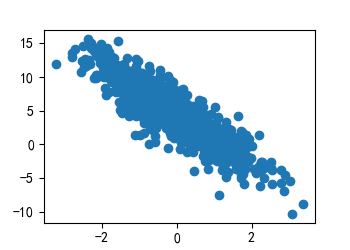

In [54]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1], labels)

In [55]:
d2l.plt.scatter(features[:, 0], labels)

### 回归方法1: 使用梯度下降的方式得到w和b

In [56]:
# 生成一个小批量样本用于更新模型
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

测试`data_iter`函数功能

In [57]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print("X.shape:", X.shape)
    print("y.shape:", y.shape)
    print(X, "\n", y)
    break

X.shape: torch.Size([10, 2])
y.shape: torch.Size([10])
tensor([[ 0.3469,  2.5516],
        [ 0.5881,  0.0514],
        [-0.1504,  0.5233],
        [ 1.2831,  1.2678],
        [-0.7783,  0.0177],
        [ 0.2877,  1.1313],
        [-1.1081,  1.1770],
        [ 1.4023,  0.4841],
        [ 1.1365,  0.7353],
        [-1.2984,  0.5426]]) 
 tensor([-3.7767,  5.2179,  2.1115,  2.4792,  2.5876,  0.9179, -2.0206,  5.3520,
         3.9715, -0.2486])


线性回归计算

In [13]:
def linreg(X, w, b):
    return torch.matmul(X, w)+b

平方损失函数

In [14]:
def squared_loss(y_hat, y):
    # 这里 y 是一个向量，而 y_hat 是一个列数为1的矩阵，需要作变换。
    return (y-y_hat.reshape(y.shape))**2/2

梯度下降函数

In [15]:
def sgd(parameters, learning_rate, batch_size):
    with torch.no_grad():
        for parameter in parameters:
            parameter -= learning_rate*parameter.grad/batch_size
            parameter.grad.zero_()  # 由于tensor默认累加梯度，这里需要清零梯度

训练模型

In [16]:
batch_size = 10  # 批量大小
num_epoches = 5  # 训练次数
learning_rate = 0.03  # 学习率

w = torch.normal(0, 0.01, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print("Original w:", w.tolist())
print("Original b:", b.tolist()[0])

parameters_save = []
for epoch in range(num_epoches):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = linreg(X, w, b)
        loss = squared_loss(y_hat, y)
        loss.sum().backward()
        parameters = [w, b]
        sgd(parameters, learning_rate, batch_size)
    with torch.no_grad():
        train_y_hat = linreg(features, w, b)
        tranin_loss = squared_loss(train_y_hat, labels)
        print(f'Epoch {epoch}, loss:{tranin_loss.mean()}')


print("After w:", w.tolist())
print("After b:", b.tolist()[0])

Original w: [[-0.009108570404350758], [-0.011253414675593376]]
Original b: 0.0
Epoch 0, loss:0.02615663968026638
Epoch 1, loss:0.00010082512017106637
Epoch 2, loss:5.179797517484985e-05
Epoch 3, loss:5.178709761821665e-05
Epoch 4, loss:5.1689694373635575e-05
After w: [[1.999679684638977], [-3.39986515045166]]
After b: 4.200601100921631


可视化误差计算梯度

### 回归方法2: 使用线性回归解析解公式得到w和b

线性回归的解析解公式为：

$$w = (X^TX)^{-1}X^Ty$$

In [17]:
w = torch.matmul(torch.matmul(torch.linalg.inv(
    torch.matmul(features.T, features)), features.T), labels)
b = labels - torch.matmul(features, w)
print("w:", w.tolist())
print("b:", b.tolist()[0])

w: [2.1273112297058105, -3.4510583877563477]
b: 4.359886169433594


## softmax 回归

### 独热（one-hot encoding）编码

独热编码是一个向量，它的分类和类别一样多。类别对应的分量设置为1，其余所有分量设置为0.

### 回归问题模型与分类问题的模型

- 回归问题（单连续数值输出，跟真实值的区别作为损失）
    - 预测房价
   
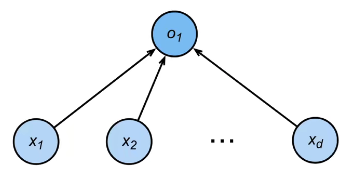


- 分类问题（通常有多个输出码，对类别进行一位有效编码）
    - MNIST: 手写数字识别 10类的分类问题
    - ImageNet: 自然物体分类 1000类的分类问题
    
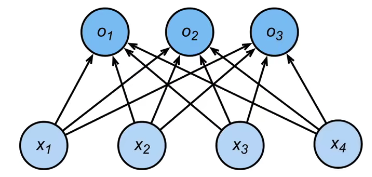



### softmax回归

softmax回归可以看作是一个单层的神经网络，并且其输出层是一个全连接层。
$$o_1 = x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} +b_1\\
o_2 = x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} +b_2 \\
o_3 = x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} +b_3$$
可以简化表示为
$$o = Wx+b$$

$$\hat{y} = \mathop{\arg\max}\limits_{i} o_i$$



- 优化目标
最大化 $P(Y|X) = \prod_{i=1}^{n} P(y^{(i)} |x^{(i)})$

相当于最小化负对数似然

$-\log{P(Y|X)} = \sum_{i=1}^{n} -\log P(y^{(i)} |x^{(i)}) = \sum_{i=1}^{n}l( y^{(i)},\hat{y}^{(i)} )$

- 损失函数

softmax优化目标中的损失函数称为交叉熵损失

$$l(y,\hat{y}) = - \sum_{j=1}^{q}y_i\log\hat{y_j}$$


- softmax 概率公式

输出匹配概率，分子保证输出结果非负，除以分母保证所有结果的和为1


$$\hat{y} = softmax(o)$$

$$\hat{y_i} = \frac{exp(o_i)}{\sum_{k}exp(o_k)}$$

- softmax 目标函数
$$arg\max_{j} \hat{y_j} = arg\max_{j} \hat{o_j}$$




### 损失函数
- 均方损失函数(L2 Loss):

    $l(y,y') = \frac{1}{2} (y-y')^2$
    
- 绝对值损失函数(L1 Loss)

    $l(y,y') = |y-y'|$
     
    优点：更加稳定
     
    缺点：零点处不可导，且零点处不稳定
     
- Huber's Robust Loss

    $l(y,y') = \left\{\begin{matrix}
|y-y'|-\frac{1}{2} & if|y-y'|>1 \\ 
\frac{1}{2}(y-y')^2& otherwise
\end{matrix}\right.$

## MNIST图像分类数据集

### 数据集准备

In [18]:
d2l.use_svg_display()
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=trans, download=True
)

print("train size:", len(mnist_train))
print("test size:", len(mnist_test))
print("image size:", mnist_train[0][0].shape)

train size: 60000
test size: 10000
image size: torch.Size([1, 28, 28])


In [19]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
labels_index = range(0, 10)
labels_en = np.array(d2l.get_fashion_mnist_labels(labels_index))
labels_zh = ['T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋', '包', '短靴']

labels = np.insert(labels_en.reshape(10, 1), 0, values=labels_index, axis=1)
labels = np.insert(labels, 2, values=labels_zh, axis=1)
labels[:, 2]

array(['T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋', '包', '短靴'],
      dtype='<U10')

可视化前18张图片。

In [58]:
def get_fashion_mnist_labels_zh(labels):
    """返回 Fashion-MNIST 数据集的中文标签"""
    text_labels = ['T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋', '包', '短靴']
    return [text_labels[int(i)] for i in labels]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
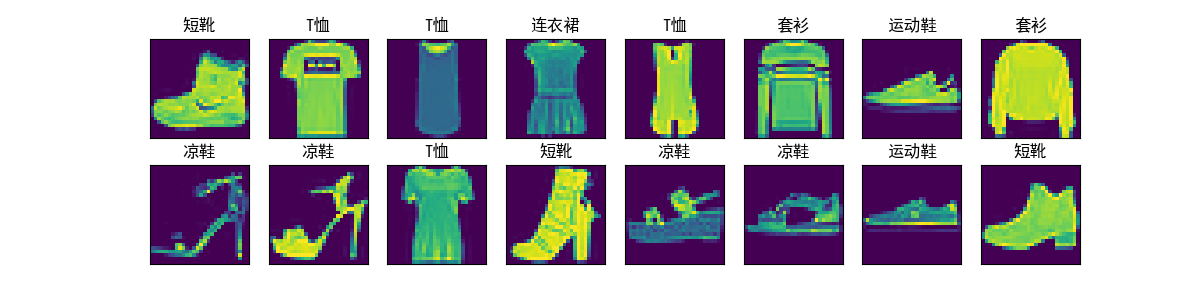

In [59]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))


d2l.show_images(
    imgs=X.reshape(18, 28, 28),
    num_rows=2,
    num_cols=8,
    titles=get_fashion_mnist_labels_zh(y),
    scale=1.5,
);

设置批量大小，并生成训练集和测试集

In [22]:
batch_size = 256

# 在Windows下需要设置num_workers=0 （默认状态）
train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True)
test_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=False)

In [ ]:
%%time

for X, y in train_iter:
    continue

Wall time: 5.67 s


## softmax实现1: 不使用高级API

#### 使用softmax

每一个元素都是正数，且每一行的和为1

根据公式$\hat{y_i} = \frac{exp(o_i)}{\sum_{k}exp(o_k)}$，创建softmax函数

In [24]:
# x 是一个矩阵，不同行对应不同的样本，需要对每一行中的元素进行softmax
def softmax(X):
    X_exp = torch.exp(X)
    X_partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp/X_partition

In [25]:
test_X = torch.normal(0, 1, (2, 5))
test_X_softmax = softmax(test_X)
print(test_X_softmax)

# 验证每一行的和为1
print(test_X_softmax.sum(dim=1))

tensor([[0.1589, 0.2592, 0.1721, 0.0811, 0.3287],
        [0.5842, 0.1071, 0.1423, 0.0906, 0.0758]])
tensor([1.0000, 1.0000])


In [26]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [27]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W)+b)

#### 定义交叉熵损失函数
根据交叉熵损失公式
$$l(y,\hat{y}) = - \sum_{j=1}^{q}y_i\log\hat{y_j}$$
定义交叉熵损失函数

In [28]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

测试交叉熵函数

两个样本，每个样本包含三个类别的预测概率。

y第一个样本的正确分类是“0”，而在y_hat中的分类为”0“的概率为0.1

交叉上为 $- [1*\log(0.1) + 0*\log(0.3) + 0*\log(0.6)]= 2.3026$

y第二个样本的正确分类是“2”，而在y_hat中的分类为“2”的概率为0.5

交叉上为 $- [0*\log(0.3) + 0*\log(0.2) + 1*\log(0.5)]= 2.3026$


In [29]:
y_test = torch.tensor([0, 2])
y_hat_test = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy(y_hat_test, y_test)

# 验证
torch.tensor([-math.log(0.1), -math.log(0.5)])

tensor([2.3026, 0.6931])

tensor([2.3026, 0.6931])

定义预测准确度函数

In [84]:
def accuracy(y_hat, y):
    if y_hat.shape[0] != y.shape[0]:
        raise Exception("y_hat.shape != y.shape")
    cmp = y == y_hat.argmax(dim=1)
    return float(cmp.sum())


accuracy(y_hat_test, y_test)

1.0

In [10]:
d2l.use_svg_display()
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=trans, download=True
)

print("train size:", len(mnist_train))
print("test size:", len(mnist_test))
print("image size:", mnist_train[0][0].shape)

train size: 60000
test size: 10000
image size: torch.Size([1, 28, 28])


In [13]:
batch_size = 25
X, y = next(iter(data.DataLoader(mnist_train, batch_size=batch_size)))

In [3]:
# 生成一个小批量样本用于更新模型
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [105]:
def softmax(X):
    X_exp = torch.exp(X)
    X_partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp/X_partition

In [110]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


In [89]:
def accuracy(y_hat, y):
    if y_hat.shape[0] != y.shape[0]:
        raise Exception("y_hat.shape != y.shape")
    cmp = y == y_hat.argmax(dim=1)
    return float(cmp.sum())

In [111]:
batch_size = 256
num_epoches = 20  # 训练次数
learning_rate = 0.1  # 学习率


w = torch.normal(0, 0.01, (784, 10), requires_grad=True)
b = torch.zeros(10, requires_grad=True)

train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True)

for epoch in range(num_epoches):
    loss_sum = 0
    accuracy_rate_avg = 0
    first = True
    for X, y in train_iter:
        y_hat = softmax(torch.matmul(X.reshape(-1,784), w)+b)
        loss = cross_entropy(y_hat, y)
        loss.sum().backward()
        d2l.sgd([w, b], learning_rate, batch_size)
        
        accuracy_rate = accuracy(y_hat, y)/len(y)

        
        if first:
            first = False
            accuracy_rate_avg = accuracy_rate
            loss_sum = float(loss.sum())
            
        else:
            accuracy_rate_avg = (accuracy_rate+accuracy_rate_avg)/2
            loss_sum = (loss_sum+float(loss.sum()))/2
    with torch.no_grad():
        print(f'Epoch {epoch}, loss sum:{loss_sum}, accuracy rate avg:{accuracy_rate_avg}')


hello
Epoch 0, loss sum:101.03097769095932, accuracy rate avg:0.8162994492863331
hello
Epoch 1, loss sum:94.29249678025921, accuracy rate avg:0.8269570425404484
hello
Epoch 2, loss sum:89.96422193035977, accuracy rate avg:0.8054551105687939
hello
Epoch 3, loss sum:84.64144878930182, accuracy rate avg:0.8385509768055164
hello
Epoch 4, loss sum:90.44589736637673, accuracy rate avg:0.8461481739403676
hello
Epoch 5, loss sum:86.85175717092434, accuracy rate avg:0.8108281976323974
hello
Epoch 6, loss sum:81.41853918621963, accuracy rate avg:0.8177360138034323
hello
Epoch 7, loss sum:83.48247919782325, accuracy rate avg:0.8306074375187523
hello
Epoch 8, loss sum:78.58442430866623, accuracy rate avg:0.8552815616673053
hello
Epoch 9, loss sum:84.31785564729445, accuracy rate avg:0.8475827112561141
hello
Epoch 10, loss sum:90.27107288806388, accuracy rate avg:0.7830969126793828
hello
Epoch 11, loss sum:76.39843896134494, accuracy rate avg:0.8494660401581462
hello
Epoch 12, loss sum:80.073408167

In [130]:
def get_fashion_mnist_labels_zh(labels):
    """返回 Fashion-MNIST 数据集的中文标签"""
    text_labels = ['T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋', '包', '短靴']
    return [text_labels[int(i)] for i in labels]

['短靴', 'T恤', 'T恤', '连衣裙', 'T恤', '套衫']


array([<AxesSubplot:title={'center':'短靴->短靴'}>,
       <AxesSubplot:title={'center':'T恤->T恤'}>,
       <AxesSubplot:title={'center':'T恤->T恤'}>,
       <AxesSubplot:title={'center':'连衣裙->连衣裙'}>,
       <AxesSubplot:title={'center':'T恤->连衣裙'}>,
       <AxesSubplot:title={'center':'套衫->套衫'}>], dtype=object)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
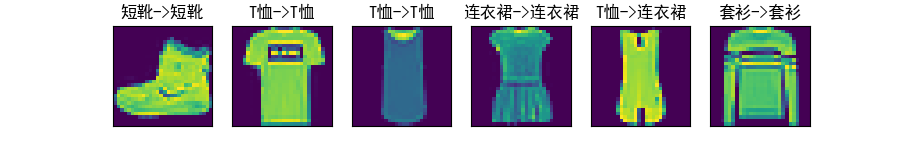

In [135]:
test_iter = data.DataLoader(mnist_train, batch_size, shuffle=False)

n = 6
for X, y in test_iter:
    trues = get_fashion_mnist_labels_zh(y)
    print(trues[:6])
    y_hat = softmax(torch.matmul(X.reshape(-1,784), w)+b).argmax(axis=1)
    # print(preds[:6])
        
    preds = get_fashion_mnist_labels_zh(y_hat)
    titles = [true +'->' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    break


## softmax实现2: 使用高级API实现 

In [42]:
batch_size = 256
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(784, 10))


def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [43]:
loss = torch.nn.CrossEntropyLoss()

In [44]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

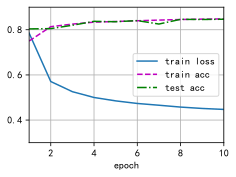

In [45]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)